In [2]:
import time
from random import random

import numpy as np
from pydrake.all import (
    DiagramBuilder,
    MeshcatVisualizer,
    MultibodyPlant,
    Parser,
    RigidTransform,
    RollPitchYaw,
    RotationMatrix,
    RandomGenerator,
    Simulator,
    SolutionResult,
    Solve,
    StartMeshcat,
)
from pydrake.multibody import inverse_kinematics

from manipulation import running_as_notebook
from manipulation.exercises.trajectories.rrt_planner.robot import (
    ConfigurationSpace,
    Range,
)
from manipulation.exercises.trajectories.rrt_planner.rrt_planning import (
    Problem,
)
from manipulation.meshcat_utils import AddMeshcatTriad
from manipulation.scenarios import MakeManipulationStation

from manipulation import ConfigureParser, running_as_notebook
from manipulation.scenarios import AddShape, ycb
from manipulation.station import MakeHardwareStation, load_scenario
from pydrake.common import temp_directory

# sponana/src/sponana/utils.py
import sponana.utils
from sponana.controller import SpotController
from sponana.debug_logger import DebugLogger
from sponana.perception import (
    add_camera_pose_extractor,
    add_body_pose_extractor,
    BananaSpotter,
)
import sponana.sim

In [3]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


Logging system info...
Camera pose: RigidTransform(
  R=RotationMatrix([
    [-0.008426761570600082, 0.49998224710719275, -0.8659946548721155],
    [0.9999644942143857, 0.0042133807853000395, -0.007297789591774128],
    [0.0, -0.8660254037844387, -0.4999999999999999],
  ]),
  p=[0.5567144695712419, -0.0037355941060653033, 0.495],
)
Table 0 pose: RigidTransform(
  R=RotationMatrix([
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0],
  ]),
  p=[0.0, 0.0, 0.19925],
)
Table 1 pose: RigidTransform(
  R=RotationMatrix([
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0],
  ]),
  p=[0.0, 2.0, 0.19925],
)
Table 2 pose: RigidTransform(
  R=RotationMatrix([
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0],
  ]),
  p=[0.0, -2.0, 0.19925],
)
Spot's state: [1.00000000e+00 1.76341229e-12 3.15001951e+00]


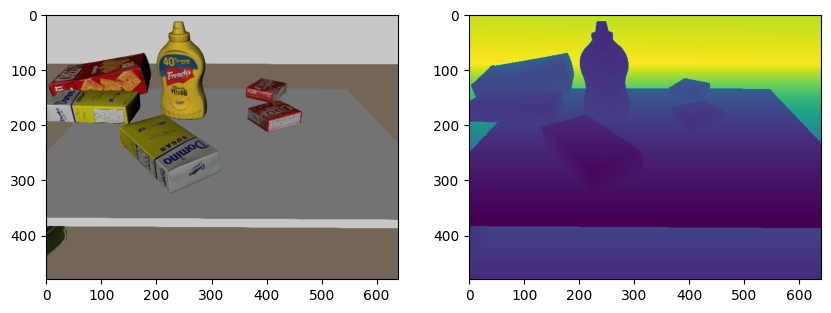

In [4]:
#Whole block here
# Clean up the Meshcat instance.
meshcat.Delete()
meshcat.DeleteAddedControls()

rng = np.random.default_rng(145)  # this is for python
generator = RandomGenerator(rng.integers(0, 1000))  # this is for c++

add_spot = True
simulation_time = -1  # run indefinitely until ESC is pressed
# simulation_time = 1
table_height = 0.2
debug = True
add_fixed_cameras = False
print("hi")
simulator, diagram = sponana.sim.clutter_gen(
    meshcat,
    rng,
    table_height=table_height,
    debug=debug,
    simulation_time=simulation_time,
    add_spot=add_spot,
    add_fixed_cameras=add_fixed_cameras,
)


In [ ]:
context = simulator.get_mutable_context()
debug_system = diagram.GetSubsystemByName("debug_logger")
context = debug_system.GetMyContextFromRoot(context)
#spot_state = debug_system.get_spot_state_input_port()
spot_state1 = debug_system.GetInputPort("spot_state").Eval(context)
spot_xytheta = spot_state1.get_value()[:3]
print("debugger_test_print:", spot_xytheta)


debugger_test_print: [ 1.00000000e+00  1.78390576e-12  3.15001886e+00  1.55407127e-11
 -3.10000000e+00  3.10000000e+00 -1.70076360e-11 -3.80690246e-11
  8.42215959e-11  2.66848365e-19 -1.11015759e-13 -1.79097787e-14
 -1.88991195e-07 -1.55997614e-13 -2.22019560e-13 -2.21619587e-13
  1.70355578e-13  3.82380285e-13 -8.45167584e-13  1.50144650e-20]


'\nspot_state = self.EvalVectorInput(context, 3 + self._num_tables)\n        if spot_state is None:\n            return\n        spot_state = spot_state.get_value()\n        # only log x, y and rotation z for now\n        print(f"Spot\'s state: {spot_state[:3]}")'

In [ ]:
class SpotProblem(Problem):
    def __init__(
        self,
        q_start: np.array,
        q_goal: np.array,
        #gripper_setpoint: float,
        left_door_angle: float,
        right_door_angle: float,
        is_visualizing=False,
    ):
        #self.gripper_setpoint = gripper_setpoint
        self.left_door_angle = left_door_angle
        self.right_door_angle = right_door_angle
        self.is_visualizing = is_visualizing

        self.collision_checker = ManipulationStationSim(
            is_visualizing=is_visualizing
        )

        # Construct configuration space for IIWA.
        plant = self.collision_checker.plant
        nq = 7
        joint_limits = np.zeros((nq, 2))
        for i in range(nq):
            joint = plant.GetJointByName("iiwa_joint_%i" % (i + 1))
            joint_limits[i, 0] = joint.position_lower_limits()
            joint_limits[i, 1] = joint.position_upper_limits()

        range_list = []
        for joint_limit in joint_limits:
            range_list.append(Range(joint_limit[0], joint_limit[1]))

        def l2_distance(q: tuple):
            sum = 0
            for q_i in q:
                sum += q_i**2
            return np.sqrt(sum)

        max_steps = nq * [np.pi / 180 * 2]  # three degrees
        cspace_iiwa = ConfigurationSpace(range_list, l2_distance, max_steps)

        # Call base class constructor.
        Problem.__init__(
            self,
            x=10,  # not used.
            y=10,  # not used.
            robot=None,  # not used.
            obstacles=None,  # not used.
            start=tuple(q_start),
            goal=tuple(q_goal),
            cspace=cspace_iiwa,
        )

    def collide(self, configuration):
        q = np.array(configuration)
        return self.collision_checker.ExistsCollision(
            q,
            self.gripper_setpoint,
            self.left_door_angle,
            self.right_door_angle,
        )
    """
    def visualize_path(self, path):
        if path is not None:
            # show path in meshcat
            for q in path:
                q = np.array(q)
                self.collision_checker.DrawStation(
                    q,
                    self.gripper_setpoint,
                    self.left_door_angle,
                    self.right_door_angle,
                )
                if running_as_notebook:
                    time.sleep(0.2)
    """

In [ ]:
class TreeNode:
    def __init__(self, value, parent=None):
        self.value = value  # tuple of floats representing a configuration
        self.parent = parent  # another TreeNode
        self.children = []  # list of TreeNodes

In [ ]:
class RRT:
    """
    RRT Tree.
    """

    def __init__(self, root: TreeNode, cspace: ConfigurationSpace):
        self.root = root  # root TreeNode
        self.cspace = cspace  # robot.ConfigurationSpace
        self.size = 1  # int length of path
        self.max_recursion = 1000  # int length of longest possible path

    def add_configuration(self, parent_node, child_value):
        child_node = TreeNode(child_value, parent_node)
        parent_node.children.append(child_node)
        self.size += 1
        return child_node

    # Brute force nearest, handles general distance functions
    def nearest(self, configuration):
        """
        Finds the nearest node by distance to configuration in the
             configuration space.

        Args:
            configuration: tuple of floats representing a configuration of a
                robot

        Returns:
            closest: TreeNode. the closest node in the configuration space
                to configuration
            distance: float. distance from configuration to closest
        """
        assert self.cspace.valid_configuration(configuration)

        def recur(node, depth=0):
            closest, distance = node, self.cspace.distance(
                node.value, configuration
            )
            if depth < self.max_recursion:
                for child in node.children:
                    (child_closest, child_distance) = recur(child, depth + 1)
                    if child_distance < distance:
                        closest = child_closest
                        child_distance = child_distance
            return closest, distance

        return recur(self.root)[0]

In [ ]:
#Other code

In [ ]:
ik_solver = IKSolver()
q_goal, optimal = ik_solver.solve(T_WG_goal, q_guess=q_start)

In [ ]:
class RRT_tools:
    def __init__(self, problem):
        # rrt is a tree
        self.rrt_tree = RRT(TreeNode(problem.start), problem.cspace)
        problem.rrts = [self.rrt_tree]
        self.problem = problem

    def find_nearest_node_in_RRT_graph(self, q_sample):
        nearest_node = self.rrt_tree.nearest(q_sample)
        return nearest_node

    def sample_node_in_configuration_space(self):
        q_sample = self.problem.cspace.sample()
        return q_sample

    def calc_intermediate_qs_wo_collision(self, q_start, q_end):
        """create more samples by linear interpolation from q_start
        to q_end. Return all samples that are not in collision

        Example interpolated path:
        q_start, qa, qb, (Obstacle), qc , q_end
        returns >>> q_start, qa, qb
        """
        return self.problem.safe_path(q_start, q_end)

    def grow_rrt_tree(self, parent_node, q_sample):
        """
        add q_sample to the rrt tree as a child of the parent node
        returns the rrt tree node generated from q_sample
        """
        child_node = self.rrt_tree.add_configuration(parent_node, q_sample)
        return child_node

    def node_reaches_goal(self, node):
        return node.value == self.problem.goal

    def backup_path_from_node(self, node):
        path = [node.value]
        while node.parent is not None:
            node = node.parent
            path.append(node.value)
        path.reverse()
        return path

In [ ]:
def rrt_planning(problem, max_iterations=1000, prob_sample_q_goal=0.05):
    """
    Input:
        problem (IiwaProblem): instance of a utility class
        max_iterations: the maximum number of samples to be collected
        prob_sample_q_goal: the probability of sampling q_goal

    Output:
        path (list): [q_start, ...., q_goal].
                    Note q's are configurations, not RRT nodes
    """
    """ Input: q_start, q_goal, max_interation, prob_sample_goal
      Output: path

      G.init(q_start)
      for k = 1 to max_interation:
        q_sample ← Generate Random Configuration
        random number ← random()
        if random_number < prob_sample_goal:
            q_sample ← q_goal
        n_near ← Find the nearest node in the tree(q_sample)
        (q_1, q_2, ... q_N) ← Find intermediate q's from n_near to q_sample
        
        // iteratively add the new nodes to the tree to form a new edge
        last_node ← n_near
        for n = 1 to N:
            last_node ← Grow RRT tree (parent_node, q_{n}) 
        
        if last node reaches the goal:
            path ← backup the path recursively
            return path
        
      return None"""
    rrt_tools = RRT_tools(iiwa_problem)
    q_goal = problem.goal
    q_start = problem.start
    i = 0 
    while i < max_iterations:
        #generate random
        q_sample = rrt_tools.sample_node_in_configuration_space()
        rand_numb = random()
        if rand_numb < prob_sample_q_goal:
            q_sample = q_goal
        n_near = rrt_tools.find_nearest_node_in_RRT_graph(q_sample)
        intermediate_qs = rrt_tools.calc_intermediate_qs_wo_collision(n_near.value, q_sample)

        last_node = n_near
        for n in range(len(intermediate_qs)):
            last_node = rrt_tools.grow_rrt_tree(n_near, intermediate_qs[n])

        if rrt_tools.node_reaches_goal(last_node):
            path = rrt_tools.backup_path_from_node(last_node)
            return path
        i +=1
    return None